# Energy Extrapolation

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/block-hczhai/block2-preview/blob/master/docs/source/tutorial/energy-extrapolation.ipynb)

In [1]:
!pip install block2==0.5.2rc13 -qq --progress-bar off --extra-index-url=https://block-hczhai.github.io/block2-preview/pypi/
!pip install pyscf==2.3.0 -qq --progress-bar off

## Introduction

In this tutorial we explain how to do DMRG energy extrapolation and also get an estimate of the error in the extrapolated energy. First we need to do a normal DMRG calculation, and then a DMRG with a reserve schedule, and then we do the energy extrapolation using the data from the reserve schedule. The DMRG energy is extrapolated using a linear fit for discarded weight vs energies for different bond dimensions. The error is estimated as one fifth of the extrapolation distance, as a convention. It is not recommended to use the normal DMRG data for the extrapolation because the energy for each bond dimension may not be fully converged. For the same reason, the energy at the largest bond dimension may also be excluded from the extrapolation.

First, we prepare the integrals and the MPO and the initial guess for the MPS.

In [2]:
import numpy as np
from pyblock2._pyscf.ao2mo import integrals as itg
from pyblock2.driver.core import DMRGDriver, SymmetryTypes

from pyscf import gto, scf

mol = gto.M(atom='C 0 0 0; C 0 0 1.2425', basis='ccpvdz', symmetry='d2h')
mf = scf.RHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_rhf_integrals(mf,
    ncore=2, ncas=26, g2e_symm=8)

print("NCAS = %d NCASELEC = %d" % (ncas, n_elec))
driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SU2,
                    stack_mem=4 << 30, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)
mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=0)
ket = driver.get_random_mps(tag="KET", bond_dim=250, nroots=1)

converged SCF energy = -75.3869023777059
NCAS = 26 NCASELEC = 8


## The Normal Schedule

First, we do a DMRG with the normal (forward) schedule (namely, the bond dimension increses). We first do 20 2-site sweeps, and then 8 1-site sweeps when it is close to convergence, which is cheaper.

To prevent optimizing to local minima, it is highly recommended to set the first bond dimension in the forward to be at least 250. If the gap of the system is small or the truncation error is large (for example, for 2D Hubbard model), one may need to do more sweeps for each bond dimension. Sometimes state averaging over multiple states (for example, setting ``nroots=4`` in ``driver.get_random_mps`` above) can help converging the ground state.

In [3]:
bond_dims = [250] * 4 + [500] * 4 + [750] * 4 + [1000] * 4
noises = [1e-4] * 4 + [1e-5] * 12 + [0]
thrds = [1e-8] * 20

energy = driver.dmrg(mpo, ket, n_sweeps=28, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1, twosite_to_onesite=20)
print('DMRG energy (variational) = %20.15f' % energy)


Sweep =    0 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-08
Time elapsed =     48.206 | E =     -75.6988045936 | DW = 4.92e-07

Sweep =    1 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-08
Time elapsed =     61.355 | E =     -75.7234052111 | DE = -2.46e-02 | DW = 4.32e-05

Sweep =    2 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-08
Time elapsed =     74.078 | E =     -75.7249238917 | DE = -1.52e-03 | DW = 6.80e-05

Sweep =    3 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-08
Time elapsed =     87.346 | E =     -75.7254307257 | DE = -5.07e-04 | DW = 6.87e-05

Sweep =    4 | Direction =  forward | Bond dimension =  500 | Noise =  1.00e-05 | Dav threshold =  1.00e-08
Time elapsed =    110.212 | E =     -75.7273558056 | DE = -1.93e-03 | DW = 3.97e-06

Sweep =    5 | Direction = backward | Bond dimensio

## The Reverse Schedule

For the reverse schedule, we decrease the bond dimension to make the energy at each bond dimension fully converged. The noise should be zero. The MPS is first changed from the 1-site format to the 2-site format. And the reverse schedule has to be done fully using the 2-site DMRG (since 1-site DMRG with zero noise will generate close-to-zero discarded weights). The energy convergence tolerance is set to zero to prevent early stop.

Note that the reverse schedule will destroy the data in the optimized MPS. We can first backup the MPS by copying it to another tag ``KET-ORIG``. If you want to later compute the properties on the optimized MPS, the ``ket_orig`` MPS should be used. If you want to restart a calculation from the MPS (automatically) stored in the scratch foloder, you can load it using its tag (for example, using ``ket = driver.load_mps(tag='KET-ORIG')``).

In practice, it is recommended to perform an even number of sweeps for each reverse schedule bond dimension, to prevent DW difference for odd/even sweeps. The first reverse schedule bond dimension should be slightly smaller than the last forward schedule bond dimension, to make sure that the energy obatined in reverse schedule is fully converged. One can also discard the energy from the first bond dimension to ensure this. The last bond dimension in reverse schedule should not be too small, since it is hard to obtain a stable energy of a very low bond dimension MPS.

In [4]:
bond_dims = [800] * 4 + [700] * 4 + [600] * 4 + [500] * 4
noises = [0] * 16
thrds = [1e-10] * 16

ket_orig = driver.copy_mps(ket, tag='KET-ORIG')
ket = driver.adjust_mps(ket, dot=2)[0]
energy = driver.dmrg(mpo, ket, n_sweeps=16, bond_dims=bond_dims, noises=noises,
                     tol=0, thrds=thrds, iprint=1)


Sweep =    0 | Direction =  forward | Bond dimension =  800 | Noise =  0.00e+00 | Dav threshold =  1.00e-10
Time elapsed =     75.765 | E =     -75.7284682749 | DW = 6.89e-06

Sweep =    1 | Direction = backward | Bond dimension =  800 | Noise =  0.00e+00 | Dav threshold =  1.00e-10
Time elapsed =    138.033 | E =     -75.7284033759 | DE = 6.49e-05 | DW = 2.47e-06

Sweep =    2 | Direction =  forward | Bond dimension =  800 | Noise =  0.00e+00 | Dav threshold =  1.00e-10
Time elapsed =    205.532 | E =     -75.7284034664 | DE = -9.04e-08 | DW = 2.42e-06

Sweep =    3 | Direction = backward | Bond dimension =  800 | Noise =  0.00e+00 | Dav threshold =  1.00e-10
Time elapsed =    310.035 | E =     -75.7284040381 | DE = -5.72e-07 | DW = 2.40e-06

Sweep =    4 | Direction =  forward | Bond dimension =  700 | Noise =  0.00e+00 | Dav threshold =  1.00e-10
Time elapsed =    388.303 | E =     -75.7283965259 | DE = 7.51e-06 | DW = 8.05e-06

Sweep =    5 | Direction = backward | Bond dimension 

## Energy Extrapolation

We can get the extrapolated energy using linear fitting.

In [5]:
import scipy.stats

ds, dws, eners = driver.get_dmrg_results()
print('BOND DIMS         = ', ds[3::4])
print('Discarded Weights = ', dws[3::4])
print('Energies          = ', eners[3::4, 0])
reg = scipy.stats.linregress(dws[3::4], eners[3::4, 0])
emin, emax = min(eners[3::4, 0]), max(eners[3::4, 0])
print('DMRG energy (extrapolated) = %20.15f +/- %15.10f' %
      (reg.intercept, abs(reg.intercept - emin) / 5))

BOND DIMS         =  [800 700 600 500]
Discarded Weights =  [2.39910258e-06 3.39687452e-06 8.41354132e-06 1.74228067e-05]
Energies          =  [-75.72840404 -75.7283302  -75.72822444 -75.72804214]
DMRG energy (extrapolated) =  -75.728429118584003 +/-    0.0000050161


Finally, we plot the energy extrapolation.

If you see a non-linear behavior, for example, the actual energy at larger bond dimension is higher than the linear fitting, it can be a signal of local minima. One may need to use increase the largest bond dimension used in the forward sweep, change the orbital ordering, or use a stricter Davidson convergence threshold (such as 1E-10).

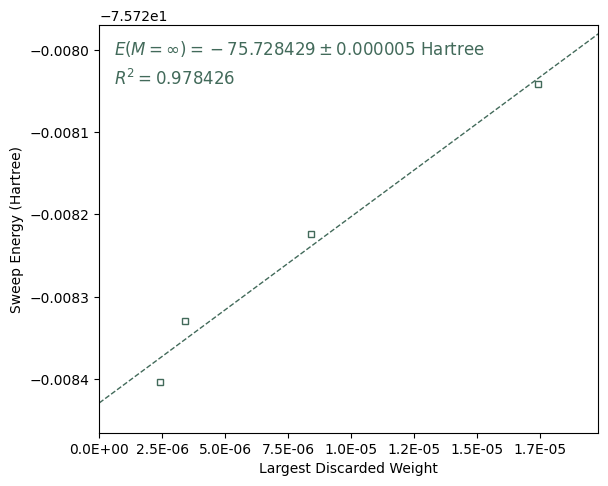

In [6]:
import matplotlib.pyplot as plt
from matplotlib import ticker
de = emax - emin
x_reg = np.array([0, dws[-1] + dws[3]])
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1E}"))
plt.plot(x_reg, reg.intercept + reg.slope * x_reg, '--', linewidth=1, color='#426A5A')
plt.plot(dws[3::4], eners[3::4, 0], ' ', marker='s', mfc='white', mec='#426A5A', color='#426A5A', markersize=5)
plt.text(dws[3] * 0.25, emax + de * 0.1, "$E(M=\\infty) = %.6f \\pm %.6f \\mathrm{\\ Hartree}$" %
    (reg.intercept, abs(reg.intercept - emin) / 5), color='#426A5A', fontsize=12)
plt.text(dws[3] * 0.25, emax - de * 0.0, "$R^2 = %.6f$" % (reg.rvalue ** 2),
    color='#426A5A', fontsize=12)
plt.xlim((0, dws[-1] + dws[3]))
plt.ylim((reg.intercept - de * 0.1, emax + de * 0.2))
plt.xlabel("Largest Discarded Weight")
plt.ylabel("Sweep Energy (Hartree)")
plt.subplots_adjust(left=0.17, bottom=0.1, right=0.95, top=0.95)